In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import uproot
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, TreeMakerSchema

from coffea.analysis_tools import Weights, PackedSelection

import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

ak.behavior.update(candidate.behavior)

from HNLprocessor.HNLproc_4 import MyProcessor
from  HNLprocessor.histograms import *

class TTbarProcessor(MyProcessor):
    def __init__(self,isElectronChannel=True,saveSkim=False,debug=False):
        super().__init__(isElectronChannel,saveSkim,debug)
        hdict={
             "nbjet": hist.Hist("Events",dataset_axis,region_axis,
                hist.Bin("nbjet", "nbjet", 4, 0, 4)
            ),     
        }
        histograms.update(hdict)
        self._accumulator = processor.dict_accumulator( histograms )
        
    def process(self, events):
        output = self.accumulator.identity()

        llp      = self.buildLLP(events)
        good_lep,ele,muons = self.buildGoodLeptons(events) 
        cluster = self.buildCSCcluster(events,good_lep)
        dt_cluster = self.buildDTcluster(events,good_lep)
        clusterMasks = self.selectCSCcluster(cluster,events)
        dt_clusterMasks = self.selectDTcluster(dt_cluster,events)
        
        selectionMasks =   {}

        selectionMasks['Acceptance_csc']   =ak.firsts(events.gLLP_csc)==1
        selectionMasks['Acceptance_dt']=ak.firsts(events.gLLP_dt)==1
        selectionMasks['METfilters']   =events.Flag2_all==True
        selectionMasks['trigger_ele']  =events.SingleEleTrigger==True
        selectionMasks['trigger_mu']   =events.SingleMuonTrigger==True
        selectionMasks['good_lepton']  =ak.num(good_lep,axis=1)==1
        selectionMasks['MET']          =events.metEENoise>=30
        selectionMasks['n_cls']        =ak.num(cluster,axis=1)>=1
        selectionMasks['n_cls_dt']     =ak.num(dt_cluster,axis=1)>=1

        CSC_sel_ABCD = ["ME11_12_veto","jetVeto","muonVeto","MB1seg_veto","RB1_veto",
                        "IntimeCut","timeSpreadCut","ClusterID"]
        CSC_sel_OOT  = ["ME11_12_veto","jetVeto","muonVeto","MB1seg_veto","RB1_veto",
                        "OOT_timeCut","timeSpreadCut","ClusterID"]

        selectionMasks['cls_ABCD']  = self.buildMask(clusterMasks,CSC_sel_ABCD)
        selectionMasks['cls_OOT']   = self.buildMask(clusterMasks,CSC_sel_OOT)

        DT_sel_OOT   = ["dt_MB1veto","dt_jetVeto","dt_muonVeto","dt_RPC","dt_MB1adj","dt_OOT"]
        DT_sel_ABCD  = ["dt_MB1veto","dt_jetVeto","dt_muonVeto","dt_RPC","dt_MB1adj","dt_time"]
        DT_sel_vetos = ["dt_MB1veto","dt_jetVeto","dt_muonVeto","dt_RPC","dt_MB1adj"]

        selectionMasks['dt_cls_OOT']  = buildMask(dt_clusterMasks,DT_sel_OOT)
        selectionMasks['dt_cls_ABCD']  = buildMask(dt_clusterMasks,DT_sel_ABCD)
        selectionMasks['dt_JetMuStaVeto'] =  buildMask(dt_clusterMasks,DT_sel_vetos)

        
        
        if self.isElectronChannel:
            preselections = ['trigger_ele','MET',"METfilters",'good_lepton']
        else:
            preselections = ['trigger_mu','MET',"METfilters",'good_lepton']
        return output

    def postprocess(self, accumulator):
        return accumulator

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
dataset_axis = hist.Cat("dataset", "Dataset")
region_axis  = hist.Cat("region", "region")
hdict={
 "nbjet": hist.Hist("Events",dataset_axis,region_axis,
    hist.Bin("nbjet", "nbjet", 4, 0, 4)
),     
}

In [31]:
histograms["nbjet"]

<Hist (dataset,region,nbjet) instance at 0x7f78a1cf80d0>

In [2]:
def getLZDF(f,nEvents=-1,treename="MuonSystem"):
    events_raw = uproot.open(f)[treename]
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events



In [7]:
import importlib

import HNLprocessor.TTbar_proc
import HNLprocessor.HNLproc_4
importlib.reload(HNLprocessor.TTbar_proc)
importlib.reload(HNLprocessor.HNLproc_4)
from HNLprocessor.TTbar_proc import ttbarProcessor

In [98]:
t = ttbarProcessor()

In [8]:
fileset = {
     'EGamma_2018A':["/uscms/home/kkwok/lpclonglived/HNL/skim_recoMu/EGamma_2018A/HeavyNeutralLepton_Tree_0.root"]
}

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=ttbarProcessor(debug=True),
    executor=processor.iterative_executor,
    executor_args={
        "schema": BaseSchema,
    },
     maxchunks=1,
     chunksize=100
)

Output()

Processing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/1 [ 0:00:00 < -:--:-- | ? chunk/s ]

bjets before 101

bjets after 101

bjets [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

length of w 101

EGamma_2018A

Weight statistics: {}

PreSel ['trigger_ele', 'MET', 'METfilters', 'good_lepton', 'n_bjets', 'bjet_cls_dr', 
'bjet_dt_cls_dr']

{'Acceptance_csc': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'Acceptance_dt': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'METfilters': <Array [True, True, True, ... True, True, True] type='101 * bool'>, 
'trigger_ele': <Array [True, False, True, ... True, True] type='101 * bool'>, 'trigger_mu': 
<Array [False, False, False, ... False, False] type='101 * bool'>, 'good_lepton': <Array 
[False, False, True, ... True, False] type='101 * bool'>, 'MET': <Array [True, True, True, 
... True, True] type='101 * bool'>, 'n_cls': <Array [False, False, False, ... False, False] 
type='101 * bool'>, 'n_cls_dt': <Array [False, False, False, ... False, False] type='101 * 
bool'>, 'n_bjets': <Array [False, False, False, ... False, False] type='101 * bool'>, 
'cls_ABCD': <Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_OOT': 
<Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_negME11': <Array 
[[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_OOT': <Array [[], [], 
[], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_ABCD': <Array [[], [], [], [], 
... [], [], [], []] type='101 * var * bool'>, 'dt_cls_negMB1': <Array [[], [], [], [], ... 
[], [], [], []] type='101 * var * bool'>, 'bjet_cls_dr': <Array [True, True, True, ... True, 
True, True] type='101 * bool'>, 'bjet_dt_cls_dr': <Array [True, True, True, ... True, True, 
True] type='101 * bool'>}

cut before 101

cut after 101

ABCD ['trigger_ele', 'MET', 'METfilters', 'good_lepton', 'n_bjets', 'bjet_cls_dr', 
'bjet_dt_cls_dr', 'cls_ABCD']

{'Acceptance_csc': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'Acceptance_dt': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'METfilters': <Array [True, True, True, ... True, True, True] type='101 * bool'>, 
'trigger_ele': <Array [True, False, True, ... True, True] type='101 * bool'>, 'trigger_mu': 
<Array [False, False, False, ... False, False] type='101 * bool'>, 'good_lepton': <Array 
[False, False, True, ... True, False] type='101 * bool'>, 'MET': <Array [True, True, True, 
... True, True] type='101 * bool'>, 'n_cls': <Array [False, False, False, ... False, False] 
type='101 * bool'>, 'n_cls_dt': <Array [False, False, False, ... False, False] type='101 * 
bool'>, 'n_bjets': <Array [False, False, False, ... False, False] type='101 * bool'>, 
'cls_ABCD': <Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_OOT': 
<Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_negME11': <Array 
[[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_OOT': <Array [[], [], 
[], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_ABCD': <Array [[], [], [], [], 
... [], [], [], []] type='101 * var * bool'>, 'dt_cls_negMB1': <Array [[], [], [], [], ... 
[], [], [], []] type='101 * var * bool'>, 'bjet_cls_dr': <Array [True, True, True, ... True, 
True, True] type='101 * bool'>, 'bjet_dt_cls_dr': <Array [True, True, True, ... True, True, 
True] type='101 * bool'>}

cut before 101

cut after 101

ABCD_dt ['trigger_ele', 'MET', 'METfilters', 'good_lepton', 'n_bjets', 'bjet_cls_dr', 
'bjet_dt_cls_dr', 'dt_cls_ABCD']

{'Acceptance_csc': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'Acceptance_dt': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'METfilters': <Array [True, True, True, ... True, True, True] type='101 * bool'>, 
'trigger_ele': <Array [True, False, True, ... True, True] type='101 * bool'>, 'trigger_mu': 
<Array [False, False, False, ... False, False] type='101 * bool'>, 'good_lepton': <Array 
[False, False, True, ... True, False] type='101 * bool'>, 'MET': <Array [True, True, True, 
... True, True] type='101 * bool'>, 'n_cls': <Array [False, False, False, ... False, False] 
type='101 * bool'>, 'n_cls_dt': <Array [False, False, False, ... False, False] type='101 * 
bool'>, 'n_bjets': <Array [False, False, False, ... False, False] type='101 * bool'>, 
'cls_ABCD': <Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_OOT': 
<Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_negME11': <Array 
[[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_OOT': <Array [[], [], 
[], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_ABCD': <Array [[], [], [], [], 
... [], [], [], []] type='101 * var * bool'>, 'dt_cls_negMB1': <Array [[], [], [], [], ... 
[], [], [], []] type='101 * var * bool'>, 'bjet_cls_dr': <Array [True, True, True, ... True, 
True, True] type='101 * bool'>, 'bjet_dt_cls_dr': <Array [True, True, True, ... True, True, 
True] type='101 * bool'>}

cut before 101

cut after 101

ABCD_negME11 ['trigger_ele', 'MET', 'METfilters', 'good_lepton', 'n_bjets', 'bjet_cls_dr', 
'bjet_dt_cls_dr', 'cls_negME11']

{'Acceptance_csc': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'Acceptance_dt': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'METfilters': <Array [True, True, True, ... True, True, True] type='101 * bool'>, 
'trigger_ele': <Array [True, False, True, ... True, True] type='101 * bool'>, 'trigger_mu': 
<Array [False, False, False, ... False, False] type='101 * bool'>, 'good_lepton': <Array 
[False, False, True, ... True, False] type='101 * bool'>, 'MET': <Array [True, True, True, 
... True, True] type='101 * bool'>, 'n_cls': <Array [False, False, False, ... False, False] 
type='101 * bool'>, 'n_cls_dt': <Array [False, False, False, ... False, False] type='101 * 
bool'>, 'n_bjets': <Array [False, False, False, ... False, False] type='101 * bool'>, 
'cls_ABCD': <Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_OOT': 
<Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_negME11': <Array 
[[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_OOT': <Array [[], [], 
[], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_ABCD': <Array [[], [], [], [], 
... [], [], [], []] type='101 * var * bool'>, 'dt_cls_negMB1': <Array [[], [], [], [], ... 
[], [], [], []] type='101 * var * bool'>, 'bjet_cls_dr': <Array [True, True, True, ... True, 
True, True] type='101 * bool'>, 'bjet_dt_cls_dr': <Array [True, True, True, ... True, True, 
True] type='101 * bool'>}

cut before 101

cut after 101

ABCD_negMB1 ['trigger_ele', 'MET', 'METfilters', 'good_lepton', 'n_bjets', 'bjet_cls_dr', 
'bjet_dt_cls_dr', 'dt_cls_negMB1']

{'Acceptance_csc': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'Acceptance_dt': <Array [False, False, False, ... False, False] type='101 * ?bool'>, 
'METfilters': <Array [True, True, True, ... True, True, True] type='101 * bool'>, 
'trigger_ele': <Array [True, False, True, ... True, True] type='101 * bool'>, 'trigger_mu': 
<Array [False, False, False, ... False, False] type='101 * bool'>, 'good_lepton': <Array 
[False, False, True, ... True, False] type='101 * bool'>, 'MET': <Array [True, True, True, 
... True, True] type='101 * bool'>, 'n_cls': <Array [False, False, False, ... False, False] 
type='101 * bool'>, 'n_cls_dt': <Array [False, False, False, ... False, False] type='101 * 
bool'>, 'n_bjets': <Array [False, False, False, ... False, False] type='101 * bool'>, 
'cls_ABCD': <Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_OOT': 
<Array [[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'cls_negME11': <Array 
[[], [], [], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_OOT': <Array [[], [], 
[], [], ... [], [], [], []] type='101 * var * bool'>, 'dt_cls_ABCD': <Array [[], [], [], [], 
... [], [], [], []] type='101 * var * bool'>, 'dt_cls_negMB1': <Array [[], [], [], [], ... 
[], [], [], []] type='101 * var * bool'>, 'bjet_cls_dr': <Array [True, True, True, ... True, 
True, True] type='101 * bool'>, 'bjet_dt_cls_dr': <Array [True, True, True, ... True, True, 
True] type='101 * bool'>}

cut before 101

cut after 101

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 [ 0:00:02 < 0:00:00 | ? chunk/s ]

Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}
Scaling with scale =  {}


../HNLprocessor/TTbar_proc.py:367: RuntimeWarning: Missing cross section for dataset EGamma_2018A.  No normalization applied. 
  scale[dataset] = lumi*corrections.load_xsection()[dataset]/dataset_sumw


In [36]:
out


{'cutflow': <Hist (dataset,region,cutflow) instance at 0x7f789fafd110>,
 'nCluster': <Hist (dataset,region,nCluster) instance at 0x7f78a02ef750>,
 'nCluster_dt': <Hist (dataset,region,nCluster) instance at 0x7f789fafd150>,
 'nCluster_n-1': <Hist (dataset,nCluster) instance at 0x7f789fafd190>,
 'accept': <Hist (dataset,gLLP_csc,gLLP_dt) instance at 0x7f789fafd1d0>,
 'ClusterSize': <Hist (dataset,region,ClusterSize) instance at 0x7f789fafd210>,
 'ClusterTime': <Hist (dataset,region,ClusterTime) instance at 0x7f789fafd250>,
 'ClusterEta': <Hist (dataset,region,ClusterEta) instance at 0x7f789fafd290>,
 'ClusterAvgStation10': <Hist (dataset,region,ClusterAvgStation10) instance at 0x7f789fafd2d0>,
 'ClusterNStation10': <Hist (dataset,region,ClusterNStation10) instance at 0x7f789fafd310>,
 'dphi_cluster_csc': <Hist (dataset,region,ClusterSize,dphi_lep,dphi_MET) instance at 0x7f789fafd350>,
 'ClusterSize_dt': <Hist (dataset,region,ClusterSize) instance at 0x7f789fafd390>,
 'ClusterTime_dt': <H

In [2]:
f = "~/lpclonglived/HNL/skim_recoMu/EGamma_2018A/HeavyNeutralLepton_Tree_0.root"
# f = "/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/test.root"
events = NanoEventsFactory.from_root(f,
                                     treepath="MuonSystem",schemaclass=BaseSchema).events()

In [7]:
p = MyProcessor()

jets = ak.zip(
    {k.replace("jet",""):getattr(events,k) for k in events.fields if k.startswith("jet")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

good_lep,ele,muons = p.buildGoodLeptons(events) 
cluster = p.buildCSCcluster(events,good_lep)
dt_cluster = p.buildDTcluster(events,good_lep)

cluster = p.buildCSCcluster(events,good_lep)        
dt_cluster = p.buildDTcluster(events,good_lep)

clusterMasks = p.selectCSCcluster(cluster,events) 
dt_clusterMasks = p.selectDTcluster(dt_cluster,events)
bjets = jets[jets.CISV>0.8484]
bjets = ak.with_field(bjets,bjets.Phi,"phi")
bjets = ak.with_field(bjets,bjets.Eta,"eta")
dphi_e = ak.fill_none(bjets.delta_phi(ak.firsts(good_lep)),-999,axis=None)
dr_e   = ak.fill_none(bjets.delta_phi(ak.firsts(good_lep)),-999,axis=None)
dphi_mu = ak.fill_none(bjets.delta_phi(ak.firsts(muons)),-999,axis=None)
dr_mu   = ak.fill_none(bjets.delta_phi(ak.firsts(muons)),-999,axis=None)

bjets= ak.with_field(bjets,dphi_e,"dphi_e")
bjets= ak.with_field(bjets,dr_e,"dr_e")
bjets= ak.with_field(bjets,dphi_mu,"dphi_mu")
bjets= ak.with_field(bjets,dr_mu,"dr_mu")

In [9]:
bjet_cls_dr = ak.all(delta_r_pairs({"cls":cluster,"bjets":bjets})[0]>0.4,axis=2)
bjet_dt_cls_dr=ak.all(delta_r_pairs({"cls":dt_cluster,"bjets":bjets})[0]>0.4,axis=2)

In [39]:
bjet_muon_dr=ak.all(delta_r_pairs({"mu":muons,"bjets":bjets})[0]>0.4,axis=2)
bjet_e_dr=ak.all(delta_r_pairs({"e":ele,"bjets":bjets})[0]>0.4,axis=2)

In [86]:
ak.all(delta_r_pairs({"cls":cluster,"bjets":bjets})[0]>0.4a)

<Array [[], [], [], [], ... [], [], [], []] type='335510 * var * var * bool'>

In [90]:
events

<NanoEventsArray [{runNum: 316985, lumiSec: 326, ... ] type='335510 * event'>

In [91]:
ak.fill_none(ak.all(bjet_cls_dr,axis=1),False)

<Array [True, True, True, ... True, True, True] type='335510 * bool'>

In [5]:
# e.g. pair_dict = {"cls":cluster,"bjets":bjets}
def delta_r_pairs(pair_dict):
    pairs = ak.cartesian(pair_dict,axis=1,nested=True)
    main_obj = getattr(pairs,pairs.fields[0])
    sec_obj = getattr(pairs,pairs.fields[1])    
    dr_pairs = main_obj.delta_r(sec_obj)       
    return dr_pairs,pairs
def delta_phi_pairs(pair_dict):
    pairs = ak.cartesian(pair_dict,axis=1,nested=True)
    main_obj = getattr(pairs,pairs.fields[0])
    sec_obj = getattr(pairs,pairs.fields[1])    
    dphi_pairs = main_obj.delta_phi(sec_obj)       
    return dphi_pairs,pairs

<Array [0.618, 2.39, 3.08, ... 4.32, 2.91] type='2578 * float32'>

In [11]:
sel =(
    (events.SingleEleTrigger==True)&
    (ak.num(good_lep,axis=1)==1)&
    (events.metEENoise>=30)
    )

(2.9805370927841195e-06, 1)

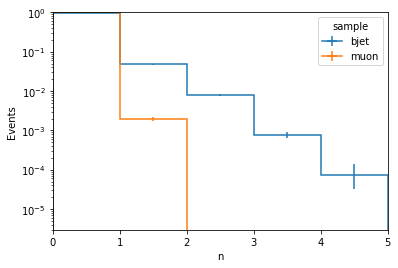

In [37]:
fig,ax = plt.subplots()
h = hist.Hist("Events",hist.Cat("sample", "sample"),
                       hist.Bin("n", "n", 5, 0, 5))
h.fill(sample="bjet",n=ak.num(bjets[sel]))
h.fill(sample="muon",n=ak.num(muons[sel]))
hist.plot1d(h,density=True,ax=ax)
ax.set_yscale("log")
ax.set_ylim(1./len(events),1)

In [32]:
bjets.dphi_e

<Array [[], [], [], [], ... [], [-999], []] type='335510 * var * float64'>

<AxesSubplot:xlabel='dphi', ylabel='Events'>

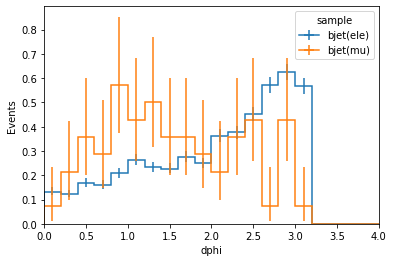

In [34]:
dphi_mu = ak.flatten(bjets[sel].dphi_mu)
dphi_e = ak.flatten(bjets[sel].dphi_e)
fig,ax = plt.subplots()
h = hist.Hist("Events",hist.Cat("sample", "sample"),
                       hist.Bin("dphi", "dphi", 20, 0, 4))
h.fill(sample="bjet(mu)" ,dphi=np.abs(dphi_mu))
h.fill(sample="bjet(ele)",dphi=np.abs(dphi_e))
hist.plot1d(h,density=True)

<AxesSubplot:xlabel='dr', ylabel='Events'>

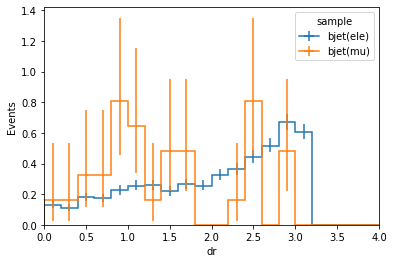

In [31]:
dr_mu = ak.flatten(bjets[sel].dr_mu)
dr_e = ak.flatten(bjets[sel].dr_e)
fig,ax = plt.subplots()
h = hist.Hist("Events",hist.Cat("sample", "sample"),
                       hist.Bin("dr", "dr", 20, 0, 4))
h.fill(sample="bjet(mu)" ,dr=dr_mu)
h.fill(sample="bjet(ele)",dr=dr_e)
hist.plot1d(h,density=True)

<AxesSubplot:xlabel='dr', ylabel='Events'>

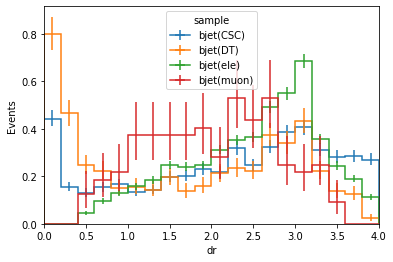

In [41]:
dr          = ak.flatten(delta_r_pairs({"cls":cluster,"bjets":bjets})[0],axis=None)
dr_dt       = ak.flatten(delta_r_pairs({"cls":dt_cluster,"bjets":bjets})[0],axis=None)
bjet_muon_dr=ak.flatten(delta_r_pairs({"mu":muons,"bjets":bjets})[0],axis=None)
bjet_e_dr   =ak.flatten(delta_r_pairs({"e":ele,"bjets":bjets})[0],axis=None)

fig,ax = plt.subplots()
h = hist.Hist("Events",hist.Cat("sample", "sample"),
                       hist.Bin("dr", "dr", 20, 0, 4))
h.fill(sample="bjet(CSC)" ,dr=dr)
h.fill(sample="bjet(DT)"  ,dr=dr_dt)
h.fill(sample="bjet(muon)",dr=bjet_muon_dr)
h.fill(sample="bjet(ele)" ,dr=bjet_e_dr)
hist.plot1d(h,density=True)

In [6]:
bjets

<PtEtaPhiMLorentzVectorArray [[], [], ... []] type='335510 * var * PtEtaPhiMLore...'>

In [30]:
clusterMasks["ME11_12_veto"][10109]

<Array [False, False] type='2 * bool'>

In [29]:
clusterMasks["ne_ME11_12_veto"][10109]

<Array [True, True] type='2 * bool'>

In [27]:
# CSC_sel_ABCD = ["ME11_12_veto","jetVeto","muonVeto","MB1seg_veto","RB1_veto",
#                         "IntimeCut","timeSpreadCut","ClusterID"]
clusterMasks["ne_ME11_12_veto"] = ~clusterMasks['ME11_12_veto']

In [7]:
bjets.fields

['Met_dPhi',
 'Met_dPhiMin',
 'Met_dPhiMin4',
 'E',
 'Pt',
 'Eta',
 'Phi',
 'Time',
 'PassId',
 'CISV',
 'CMVA',
 'PtJESUp',
 'PtJESDown',
 'EJESUp',
 'EJESDown',
 '_match_genJet_pt',
 '_match_genJet_index',
 '_match_genJet_minDeltaR',
 'TightPassId',
 'MuonEnergyFraction',
 'ElectronEnergyFraction',
 'PhotonEnergyFraction',
 'ChargedHadronEnergyFraction',
 'NeutralHadronEnergyFraction']

In [7]:
cluster.eta

<Array [[], [], [], [], ... [], [], [], []] type='335510 * var * float32[paramet...'>

In [25]:
bjets.dphi_bjet_e

<Array [[], [], [], [], ... [], [-999], []] type='335510 * var * float64'>

In [23]:
bjets= ak.with_field(bjets,dphi_bjet_e,"dphi_bjet_e")

In [8]:
bjets.delta_phi(ak.firsts(ele))

<Array [None, None, [], ... None, None, None] type='335510 * option[var * float32]'>

In [22]:
dphi_bjet_e = ak.fill_none(bjets.delta_phi(ak.firsts(ele)),-999,axis=None)
dr_bjet_e   = ak.fill_none(bjets.delta_phi(ak.firsts(ele)),-999,axis=None)


In [21]:
np.where(ak.num(muons)>1)

(<Array [7332, 170517, ... 293669, 302007] type='5 * int64'>,)

In [15]:
dr_bjet_cls>0.4

<Array [False, False, False, ... False, False] type='335510 * union[var * bool, ...'>

In [11]:
all_dr = ak.all(delta_r_pairs({"cls":cluster,"bjets":bjets})[0]>0.4,axis=2)

In [12]:
dr,bjet_pairs = delta_r_pairs({"cls":cluster,"bjets":bjets})

In [13]:
np.where((ak.num(bjets)>0)&(ak.num(cluster)>1))

(<Array [10109, 10850, ... 330324, 332152] type='79 * int64'>,)

In [14]:
cluster[10109]

<PtEtaPhiMLorentzVectorArray [{time: 14.5, ... dr_cluster_lep: -999}] type='2 * ...'>

In [15]:
bjets[10109]

<PtEtaPhiMLorentzVectorArray [... phi: 0.664, eta: -1.12}] type='1 * PtEtaPhiMLo...'>

In [16]:
dr

<Array [[], [], [], [], ... [], [], [], []] type='335510 * var * var * float32'>

In [21]:
ak.any(dr<3,axis=2)[10109]

<Array [True, False] type='2 * bool'>

In [15]:
bjet_pairs.bjets[dr<3][10109].to_list()

[[{'Met_dPhi': -3.0718295574188232,
   'Met_dPhiMin': 0.004399776458740234,
   'Met_dPhiMin4': 0.004399776458740234,
   'E': 82.59855651855469,
   'Pt': 48.28376388549805,
   'Eta': -1.124759316444397,
   'Phi': 0.6635959148406982,
   'Time': 0.0,
   'PassId': False,
   'CISV': 0.9128515124320984,
   'CMVA': 0.0,
   'PtJESUp': 49.328521728515625,
   'PtJESDown': 47.23900604248047,
   'EJESUp': 84.38581085205078,
   'EJESDown': 80.8113021850586,
   '_match_genJet_pt': -999.0,
   '_match_genJet_index': -999,
   '_match_genJet_minDeltaR': -999.0,
   'TightPassId': True,
   'MuonEnergyFraction': -999.0,
   'ElectronEnergyFraction': -999.0,
   'PhotonEnergyFraction': -999.0,
   'ChargedHadronEnergyFraction': -999.0,
   'NeutralHadronEnergyFraction': -999.0,
   'phi': 0.6635959148406982,
   'eta': -1.124759316444397}],
 []]

In [ ]:
ak.any(dr<0.4,axis=1)[10109]

In [44]:
bjet_pairs.bjets[10109]

<PtEtaPhiMLorentzVectorArray [[{Met_dPhi: -3.07, ... eta: -1.12}]] type='2 * var...'>

In [43]:
bjet_pairs.cls[10109]

<PtEtaPhiMLorentzVectorArray [[{time: 14.5, ... ] type='2 * var * PtEtaPhiMLoren...'>

In [13]:
all_dr

<Array [[], [], [], [], ... [], [], [], []] type='335510 * var * bool'>

In [28]:
print(cluster[628].eta)
print(cluster[628].phi)

[2.01]
[2.04]


In [25]:
print(bjets[628].eta)
print(bjets[628].phi)

[1.7, 2]
[-1.02, 1.53]


In [ ]:
np.where((ak.num(bjets)>0)&(ak.num(cluster)>0))

In [27]:
bjets[]

<PtEtaPhiMLorentzVectorArray [[], [], [], [], ... [], [], [], []] type='335510 *...'>

In [21]:
pair = ak.cartesian({"cls":cluster,'bjets':bjets},axis=1,nested=True)
# dphi_lep_cls = cls_lep_pair.cls.delta_phi(cls_lep_pair.lep)       


In [47]:
cluster.fields

['time',
 'size',
 'timeSpread',
 'eta',
 'phi',
 'x',
 'y',
 'z',
 'llp_x',
 'llp_y',
 'llp_z',
 'NChamber',
 'MaxChamber',
 'MaxStation',
 'NStation10',
 'AvgStation10',
 'ME11_12',
 'llp_match',
 'RE12',
 'MB1seg',
 'RB1',
 'MuonVetoPt',
 'MuonVetoEta',
 'JetVetoPt',
 'JetVetoEta',
 'dphi_cluster_MET',
 'dphi_cluster_lep',
 'dr_cluster_lep']

In [45]:
bjets.fields

['Met_dPhi',
 'Met_dPhiMin',
 'Met_dPhiMin4',
 'E',
 'Pt',
 'Eta',
 'Phi',
 'Time',
 'PassId',
 'CISV',
 'CMVA',
 'PtJESUp',
 'PtJESDown',
 'EJESUp',
 'EJESDown',
 '_match_genJet_pt',
 '_match_genJet_index',
 '_match_genJet_minDeltaR',
 'TightPassId',
 'MuonEnergyFraction',
 'ElectronEnergyFraction',
 'PhotonEnergyFraction',
 'ChargedHadronEnergyFraction',
 'NeutralHadronEnergyFraction']

In [6]:
lumi = 0.939
br = 1
xsec = 56000*1000 *br
nevts_WJ = out['sumw']['WJetsToLNu']
nevts_data = out['sumw']['EGamma_2018A']

w_WJ = lumi * xsec / nevts_WJ
print('nevts_WJ = ',nevts_WJ )
print('nevts_data = ',nevts_data )
print('weight = ',lumi * xsec / nevts_WJ)


nevts_WJ =  22389133.0
nevts_data =  22198219.0
weight =  2.348639404661181


In [46]:
out['ClusterSize'][0:1].identifiers("dataset")

[<StringBin (EGamma_2018A) instance at 0x7f4eaba88450>]

In [125]:
out['ClusterSize'][1:,::].identifiers("region")

[<StringBin (ele_JetMuStaVeto) instance at 0x7f4ea8dfd590>,
 <StringBin (ele_JetMuVeto) instance at 0x7f4ea8dfd550>,
 <StringBin (ele_OOT) instance at 0x7f4ea8dfd610>,
 <StringBin (ele_PreSel) instance at 0x7f4ea8dfd450>,
 <StringBin (ele_SR) instance at 0x7f4ea8dfd5d0>,
 <StringBin (ele_W_CR) instance at 0x7f4ea8dfd490>,
 <StringBin (ele_W_CR2) instance at 0x7f4ea8dfd4d0>,
 <StringBin (ele_rawcls) instance at 0x7f4ea8dfd510>,
 <StringBin (noselection) instance at 0x7f4ea8dfd650>]

In [82]:
out['dphi_cluster_MET'].identifiers('region')

[<StringBin (ele_NoVeto) instance at 0x7f4eabb25b10>,
 <StringBin (ele_OOT) instance at 0x7f4eabb25dd0>,
 <StringBin (ele_PreSel) instance at 0x7f4eabb250d0>,
 <StringBin (ele_SR) instance at 0x7f4eabb25910>,
 <StringBin (ele_W_CR) instance at 0x7f4eabb25590>,
 <StringBin (ele_rawcls) instance at 0x7f4eabb25750>,
 <StringBin (noselection) instance at 0x7f4eabb258d0>]

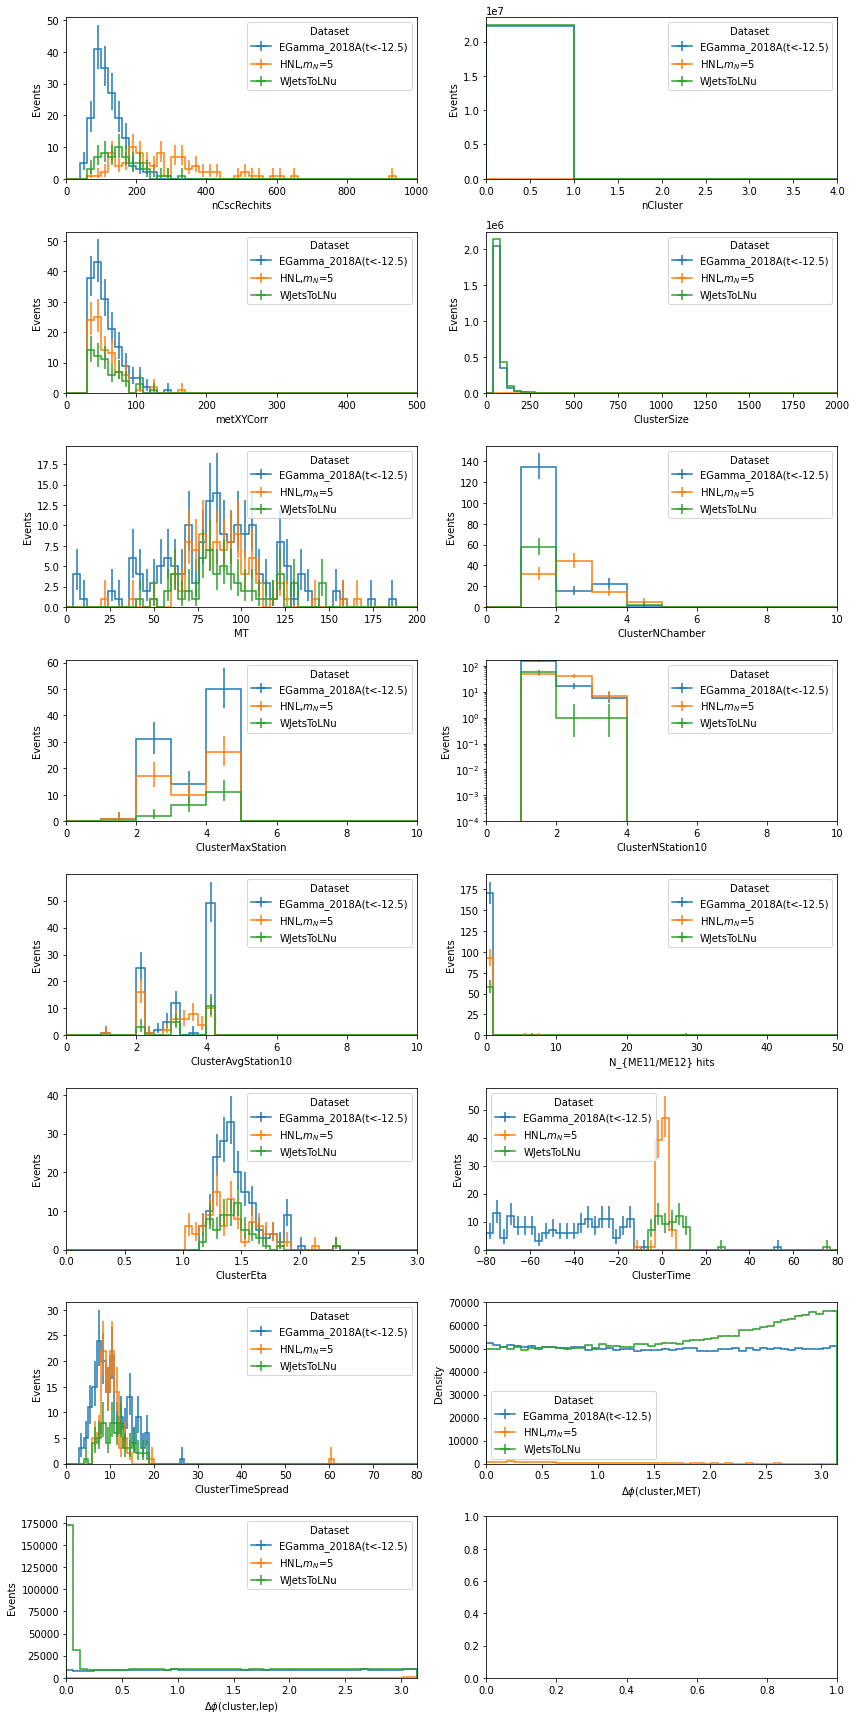

In [71]:
hists = [
    
    out["nCscRechits"],
    out["nCluster"],
    out['metXYCorr'],    
    out['ClusterSize'].project('ClusterSize','dataset'),
            out['MT'],
    out['ClusterNChamber'],
#     out['ClusterMaxChamber'],
    out['ClusterMaxStation'],
    out['ClusterNStation10'],
    out['ClusterAvgStation10'],
    out['ClusterME11_ME12'],    
    out['ClusterEta'],    
    out['ClusterTime'],
    out['ClusterTimeSpread'],
    out['dphi_cluster_MET'].project("dphi_cluster_MET","dataset"),
    out['dphi_cluster_lep'].project('dphi','dataset')
]

ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

# lumi = 4.321
# br = 0.3
# xsec = 56000*1000 *br
# nevts_WJ = out['sumw']['WJetsToLNu']
# nevts_data = out['sumw']['SingleMu 2017B(t<-12.5)']

# print('nevts_WJ = ',nevts_WJ )
# print('nevts_data = ',nevts_data )
# print('weight = ',lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
#     h.label='Density'
#     hplot = h.copy()
#     hplot.scale({"WJetsToLNu": lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ}, "dataset")    
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=False,clear=False)

# axs[2].set_ylim(1e-4,None);axs[2].set_yscale('log')    
# axs[8].set_ylim(1e-4,None);axs[8].set_yscale('log')    
axs[7].set_ylim(1e-4,None);axs[7].set_yscale('log')        

plt.tight_layout()
plt.show()

In [ ]:
h=out['clusterID']
ncols=2
nrows=2
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

hist.plot2d(h[r'HNL,$m_N$=5'].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[0])
hist.plot2d(h["SingleMu 2017B(t<-12.5)"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[1])
hist.plot2d(h["WJetstoLNu"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
h[r'HNL,$m_N$=5']

In [ ]:
v = out['Veto']
h = out['muVeto']
j = out['jetVeto']
ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

h.label='Density'

hist.plot2d(h['SingleMu 2017B(t<-12.5)'].project("time","pt"),xaxis='time',ax=axs[0])

# for i,name in enumerate(['muVeto','jetVeto']):
#     hist.plot1d(v.project(name,'dataset'),ax=axs[i], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','time','eta','LooseId','LooseIso']):
for i,name in enumerate(['pt','time','eta']):
    hist.plot1d(h.project(name,'dataset'),ax=axs[i+1], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','eta']):
#     hist.plot1d(j.project(name,'dataset'),ax=axs[i+5], overlay='dataset',density=True,clear=False)

# axs[-2].set_xlabel('jetVeto_pt')    
# axs[-1].set_xlabel('jetVeto_eta')    
    
# axs[2].set_ylim(1E-4,10);axs[2].set_yscale('log')
# axs[3].set_ylim(1E-4,10);axs[3].set_yscale('log')
plt.tight_layout()
plt.show()

h = out["gLLP_csc"]
ax = hist.plot1d(h, overlay='dataset',density=True,clear=False)
print("Efficiency in CSC:")
for ds,arr in h.values().items():
    print(ds,"{:.3f}".format(arr[1]/np.sum(arr)))

In [ ]:
h = out['dphi_cluster_lep']
hist.plotgrid(
    h,
    col='llp_matched',
    overlay='dataset',
    density=True,
)

In [ ]:
import matplotlib.patches as patches

def plotEff_efrac(h,ax,axis='e'):
    h_pass=h.integrate('selection',slice(1,None))
    h_pass.label='Signal Efficiency'

    h_EMfrac_p9=h.integrate("EMfrac",slice(0.5,None))
    h_EMfrac_p9_pass=h_EMfrac_p9.integrate("selection",slice(1,None))
    h_EMfrac_p9_pass.label='Signal Efficiency'
    
    h_EMfrac_low=h.integrate("EMfrac",slice(None,0.5))
    h_EMfrac_low_pass=h_EMfrac_low.integrate("selection",slice(1,None))
    h_EMfrac_low_pass.label='Signal Efficiency'
    
    hist.plotratio(
    ax=ax,
    num=h_pass.project(axis),
    denom=h.project(axis),
    error_opts={ 'marker': '.'},
    unc='clopper-pearson',
    label='Inclusive'
    )

    hist.plotratio(
        ax=ax,
        num=h_EMfrac_p9_pass.project(axis),
        denom=h_EMfrac_p9.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac>0.5'
    )
    hist.plotratio(
        ax=ax,
        num=h_EMfrac_low_pass.project(axis),
        denom=h_EMfrac_low.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac<0.5'
    )    
    ax.legend(loc='best')
    return ax

def plotEff(h_list,ax,axis='e'):
    for h in h_list:
        h_pass=h.integrate('selection',slice(1,None))
        h_pass.label='Signal Efficiency'
        
        hist.plotratio(
            ax=ax,
            num=h_pass.project(axis),
            denom=h.project(axis),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label=h.identifiers('dataset')[0].name,
            clear=False
        )

    ax.legend(loc='best')
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-110 ,y_max*0.05, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.05, "Outer ring", fontsize=15)
    return ax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

In [ ]:
h=out['llp'][2:]

ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()

for i,d in enumerate(['selection','e','EMfrac','z','r']):
    hist.plot1d(h.project(d,'dataset'),ax=axs[i],overlay="dataset",density=True)

plotEff_efrac(         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],axs[5],'z')    
    
axs[5] = drawCSCz(axs[5])    
# plotEff([         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#          h[r'HNL,$m_N$=5'],                  
#          ],axs[5],'e')
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[6],'z')
# axs[6].set_ylim(0,2)
# axs[6] = drawCSCz(axs[6])
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[7],'r')
# axs[7] = drawCSCr(axs[7])
plt.tight_layout()